# How to Train Neural Networks

**References**:

* Notes and tutorials from other courses:
  - [ECE521 (Winter 2017)](https://ece521.github.io/) tutorial on [Training neural network](http://www.psi.toronto.edu/~jimmy/ece521/Tut2.pdf)
  - [Stanford's CS231n](https://cs231n.github.io/) notes on [Stochastic Gradient Descent](https://cs231n.github.io/optimization-1/), [Setting up data and loss](https://cs231n.github.io/neural-networks-2/), and [Training neural networks](https://cs231n.github.io/neural-networks-3/)
  - [Deeplearning.ai's](https://www.deeplearning.ai/) interactive notes on [Initialization](https://www.deeplearning.ai/ai-notes/initialization/) and [Parameter optimization in neural networks](https://www.deeplearning.ai/ai-notes/optimization/) 
  - Jimmy Ba's Talk for [Optimization in Deep Learning](https://www.youtube.com/watch?v=eHEkbDHVDuI) at [Deep Learning Summer School 2019](https://dlrlsummerschool.ca/)
* Academic/white papers:
  - [SGD](https://www.microsoft.com/en-us/research/publication/stochastic-gradient-tricks/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F192769%2Ftricks-2012.pdf) tips and tricks from Leon Bottou
  - [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) from Yann LeCun
  - [Practical Recommendations for Gradient-Based Training of Deep Architectures](https://arxiv.org/pdf/1206.5533v2.pdf) from Yoshua Bengio

## The Big Picture of Training Loop

![Training Loop Diagram](https://drive.google.com/uc?id=1c79evEvqEwvgDbEO9-ZDwUArA2BK2_sC)

The training loop consist of these steps:
* Initialize the parameters $\theta$ of your network
* Loop until convergence:
  - Sample batch of input/output pairs
  - Compute forward propagation $h(x;\theta)$ of the input with your model
  - Compute the loss function $\mathcal{L}(h(x; \theta), y)$ 
  - Update the parameters in $\theta$ using the optimizer

We will discuss:
1. **Initialization**: Xavier, He, Uniform, etc.
2. **Optimizers**: SGD, Momentum, Nesterov Momentum, Adagrad, RMSProp, Adam
3. **Hyperparameters tuning**: learning rate (initial & decay schedule), batch size

## Skeletal Training Code

We first show a typical training loop code in PyTorch, based on the previous tutorial

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Define the architecture. In this case, just an MLP

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim=784, num_hidden=300, output_dim=10, activation_func=torch.relu):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, num_hidden)
    self.fc2 = nn.Linear(num_hidden, num_hidden)
    self.fc3 = nn.Linear(num_hidden, num_hidden)
    self.fc4 = nn.Linear(num_hidden, output_dim)
    self.activation_func = activation_func

  def forward(self, x):
    h1 = self.activation_func(self.fc1(x))
    h2 = self.activation_func(self.fc2(h1))
    h3 = self.activation_func(self.fc3(h2))
    out = self.fc4(h3)
    
    return out, [h1, h2, h3]

Load the MNIST dataset for experiment (as from previous tutorial)

In [ ]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21393209.73it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 331930.04it/s]
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 4741275.01it/s]                          
8192it [00:00, 132994.28it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


  0%|          | 16384/9912422 [00:00<01:24, 116695.81it/s]

9920512it [00:00, 24298779.54it/s]                           


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 319512.53it/s]                           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 5290340.23it/s]                           
8192it [00:00, 132616.49it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


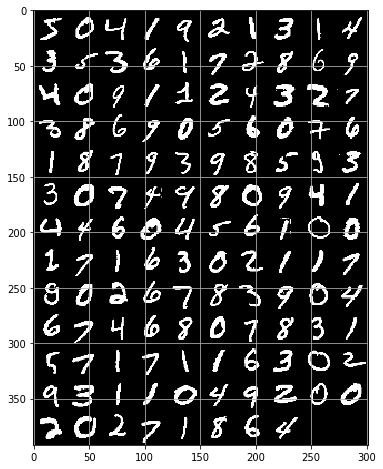

In [ ]:
from torch.utils.data import DataLoader
import torchvision

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,),(0.3081,)),
                    ]))

mnist_test = datasets.MNIST('data', train=False, download=True, 
                            transform = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,),(0.3081,)),
                    ]))

bs = 128
train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size = 100)

dataiter = iter(train_dl)
images, labels = dataiter.next()
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.grid(None)

In [ ]:
def train_model(model, optimizer, train_loader, test_loader, epochs=100, print_every=10, debug=False):
  if debug:
    # Visualize the initial weights  
    weights_list = []
    for i, module in enumerate(model.modules()):
      if isinstance(module, nn.Linear):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        weights_list.append(weights)
    
    num_weight_layers = len(weights_list)
    fig, ax = plt.subplots(nrows=1, ncols=num_weight_layers, figsize=(5*num_weight_layers,5))
    for i in range(num_weight_layers):
      plt.subplot(1,num_weight_layers, i+1)
      plt.hist(weights_list[i])
      plt.title("Init Weights (Layer {}-{})".format(i, i+1))
    plt.show()

  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  train_accs = []
  test_accs = []
  train_losses = []
  test_losses = []
  
  # Using GPUs in PyTorch is pretty straightforward
  if torch.cuda.is_available():
      print("Using cuda")
      use_cuda = True
      device = torch.device("cuda")
  else:
      device = "cpu"
  
  # Move the model to GPU, if available
  model.to(device)    
  model.train()
  
  for epoch in range(epochs):
    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    for i, (inputs, labels) in enumerate(train_loader): 
      model.zero_grad()
      inputs = inputs.to(device)
      labels = labels.to(device)
      inputs = inputs.view(inputs.size(0), -1) # Flatten input from [batch_size, 1, 28, 28] to [batch_size, 784]
      pred, activations = model(inputs)
      xentropy_loss = criterion(pred, labels)
      xentropy_loss.backward()

      optimizer.step()

      if debug and epoch == 0 and i == 0:
        # Inspect gradients
        grad_list = []
        for layer_index, param in enumerate(model.parameters()):
          if layer_index % 2 == 0:
            # These are the weights (not biases)
            grad = param.grad.reshape(-1).detach().cpu().numpy()
            grad_list.append(grad)

        plot_grad_histograms(grad_list, epoch, init=True)

        # Plot activation
        act_list = []
        for act in activations:
          act = act.reshape(-1).detach().cpu().numpy()
          act_list.append(act)
        
        plot_act_histograms(act_list, epoch, init=True)

      xentropy_loss_avg += xentropy_loss.item()

      # Calculate running average of accuracy
      pred = torch.max(pred.data, 1)[1]
      total += labels.size(0)
      correct += (pred == labels.data).sum().item()
    accuracy = correct / total

    test_acc, test_loss = evaluate(model, test_loader, criterion, device)
    if epoch % print_every == 0:
      print("Epoch {}, Train acc: {:.2f}%, Test acc: {:.2f}%".format(epoch, accuracy*100, test_acc*100))

      if debug:
        # Inspect gradients
        grad_list = []
        for layer_index, param in enumerate(model.parameters()):
          if layer_index % 2 == 0:
            # These are the weights (not biases)
            grad = param.grad.reshape(-1).detach().cpu().numpy()
            grad_list.append(grad)
        plot_grad_histograms(grad_list, epoch)

        # Plot activation
        act_list = []
        for act in activations:
          act = act.reshape(-1).detach().cpu().numpy()
          act_list.append(act)
        plot_act_histograms(act_list, epoch)

    train_accs.append(accuracy)
    test_accs.append(test_acc)
    train_losses.append(xentropy_loss_avg/i)
    test_losses.append(test_loss)

  return train_accs, test_accs, train_losses, test_losses

def evaluate(model, loader, criterion, device):
  model.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
  correct = 0.
  total = 0.
  val_loss = 0.
  for i, (inputs, labels) in enumerate(loader):
    with torch.no_grad():
      inputs = inputs.to(device)
      labels = labels.to(device)
      inputs = inputs.view(inputs.size(0), -1) 
      pred, activations = model(inputs)
      xentropy_loss = criterion(pred, labels)
      val_loss += xentropy_loss.item()

    pred = torch.max(pred.data, 1)[1]
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc = correct / total
  val_loss = val_loss / i 
  model.train()
  return val_acc, val_loss
  
def plot_grad_histograms(grad_list, epoch, init=False):
  fig, ax = plt.subplots(nrows=1, ncols=len(grad_list), figsize=(5*len(grad_list),5))
  for i, grad in enumerate(grad_list):
    plt.subplot(1,len(grad_list), i+1)
    plt.hist(grad)
    if init:
      plt.title("Grads for Weights (Layer {}-{}) Init".format(i, i+1))
    else:
      plt.title("Grads for Weights (Layer {}-{}) Epoch {}".format(i, i+1, epoch))
  plt.show()

def plot_act_histograms(act_list, epoch, init=False):
  fig, ax = plt.subplots(nrows=1, ncols=len(act_list), figsize=(5*len(act_list),5))
  for i, act in enumerate(act_list):
    plt.subplot(1,len(act_list), i+1)
    plt.hist(act)
    if init:
      plt.title("Activations for Layer {} Init".format(i+1))
    else:
      plt.title("Activations for Layer {} Epoch {}".format(i+1, epoch))
  plt.show()


In [ ]:
def plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption):
  # Visualize the loss / acc
  plt.plot(train_accs, label="Train")
  plt.plot(test_accs, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Classification Accuracy vs Epoch: {}".format(caption))


  # Visualize the loss / acc
  plt.figure()
  plt.plot(train_losses, label="Train")
  plt.plot(test_losses, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  plt.legend()
  plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

  return 

## 1. Initialization


We implement different types of initializations:
1. Zero (constant)
2. Uniform Init: $\mathcal{U}(0,1)$
3. Xavier Init:  $\mathcal{N}(0, 1/n^{l-1})$
3. He Init: \mathcal{N}(0, 2/n^{l-1})

See different types of initializations: https://pytorch.org/docs/stable/nn.init.html 

In [ ]:
def init_weights_zero(m):
  if type(m) == nn.Linear:
    m.weight.data.fill_(0.0)
    m.bias.data.fill_(0.0)

def init_weights_uniform(m):
  if type(m) == nn.Linear:
    m.weight.data.uniform_(0.0, 1.0)
    m.bias.data.fill_(0.0)

def init_weights_xavier(m):
  if type(m) == nn.Linear:
    # w ~ N(0, 1)*sqrt(1/(fan_in))
    # w ~ N(0, 1)*sqrt(2/(fan_in + fan_out)))
    # torch.nn.init.xavier_normal_(m.weight, gain=1.0)
    n = m.in_features
    std = np.sqrt(1.0/n)
    m.weight.data.normal_(0,std)
    m.bias.data.fill_(0.0)

def init_weights_kaiminghe(m):
  if type(m) == nn.Linear:
    # w ~ N(0, 1)*sqrt(1/(fan_in))
    # torch.nn.init.kaiming_normal_(m.weight, a = 0)
    n = m.in_features
    std = np.sqrt(2.0/n)
    m.weight.data.normal_(0,std)
    m.bias.data.fill_(0.0)
    
def apply_initialization(model, initialization):
  """ 
  Apply different types of initialization
  """
  if initialization == 'zero':
    model.apply(init_weights_zero)
  elif initialization == 'uniform':
    model.apply(init_weights_uniform)
  elif initialization == 'xavier':
    model.apply(init_weights_xavier)
  elif initialization == 'he':
    model.apply(init_weights_kaiminghe)
  
  return model

Let's try with our first initialization method: **zero** initialization. This sets all the weights and biases of the layers to zero. 

In [ ]:
# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='zero'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=10, print_every=2, debug=False)

Using cuda
Epoch 0, Train acc: 11.22%, Test acc: 11.35%
Epoch 2, Train acc: 11.24%, Test acc: 11.35%
Epoch 4, Train acc: 11.24%, Test acc: 11.35%
Epoch 6, Train acc: 11.24%, Test acc: 11.35%
Epoch 8, Train acc: 11.24%, Test acc: 11.35%


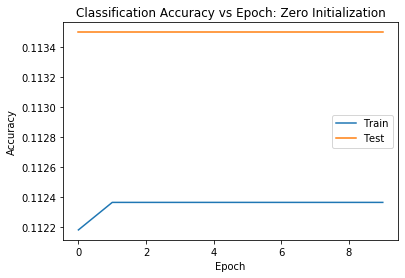

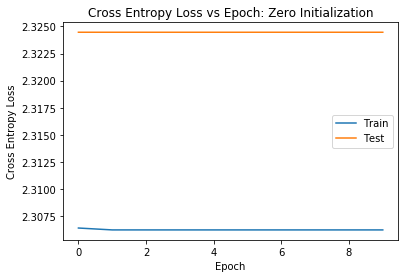

In [ ]:
caption="Zero Initialization"
plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption)

That's pretty bad 

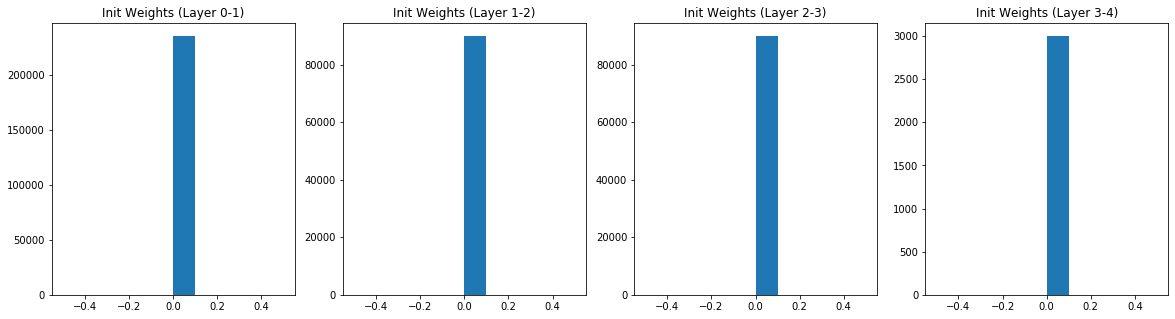

Using cuda


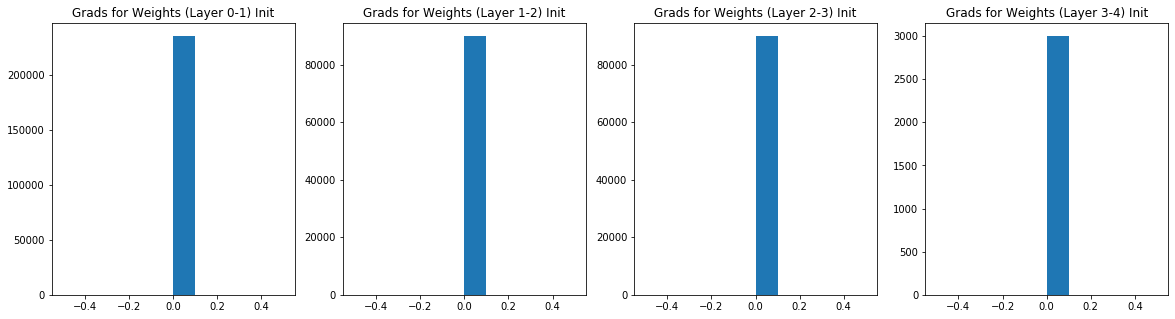

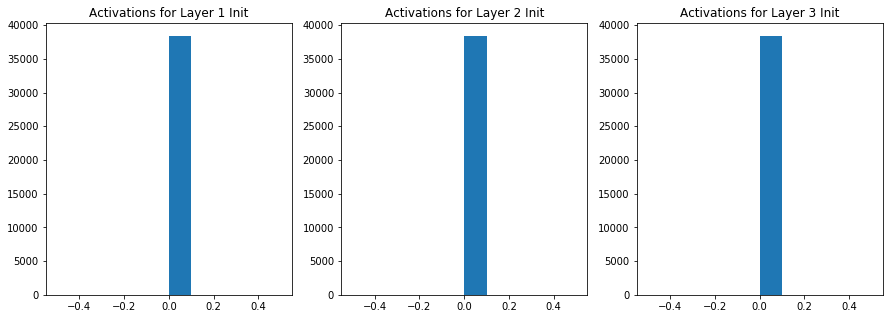

Epoch 0, Train acc: 11.22%, Test acc: 11.35%


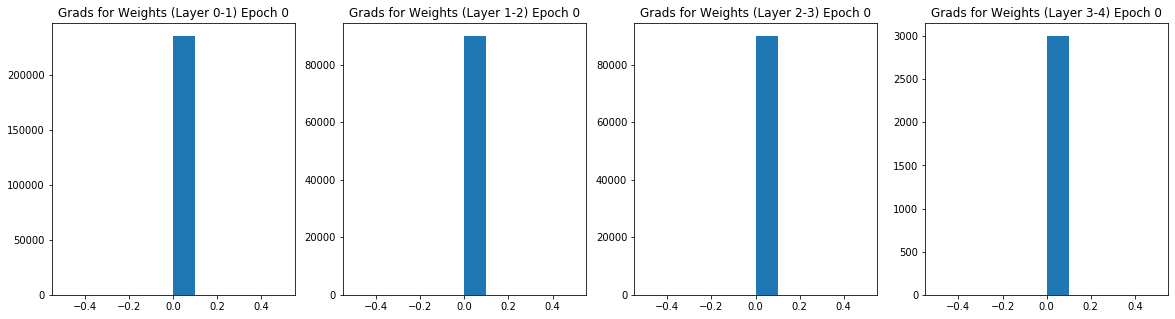

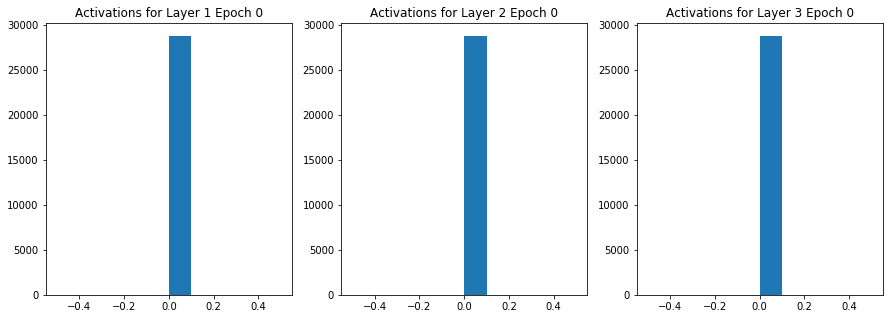

In [ ]:
# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='zero'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=2, print_every=2, debug=True)

Observation: the activations and the gradients are all zero!

In [ ]:
# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='uniform'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=10, print_every=2, debug=False)

Using cuda
Epoch 0, Train acc: 15.82%, Test acc: 16.62%
Epoch 2, Train acc: 15.75%, Test acc: 16.60%
Epoch 4, Train acc: 15.80%, Test acc: 16.73%
Epoch 6, Train acc: 15.60%, Test acc: 16.54%
Epoch 8, Train acc: 15.74%, Test acc: 17.71%


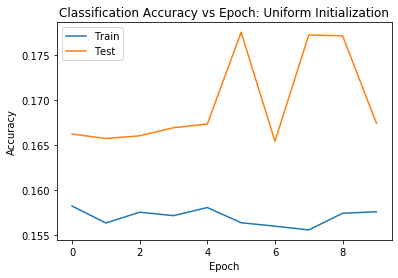

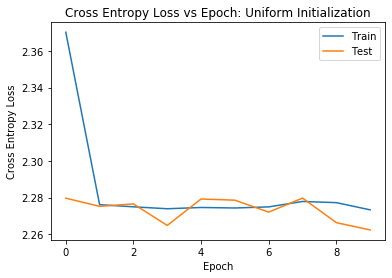

In [ ]:
caption="Uniform Initialization"
plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption)

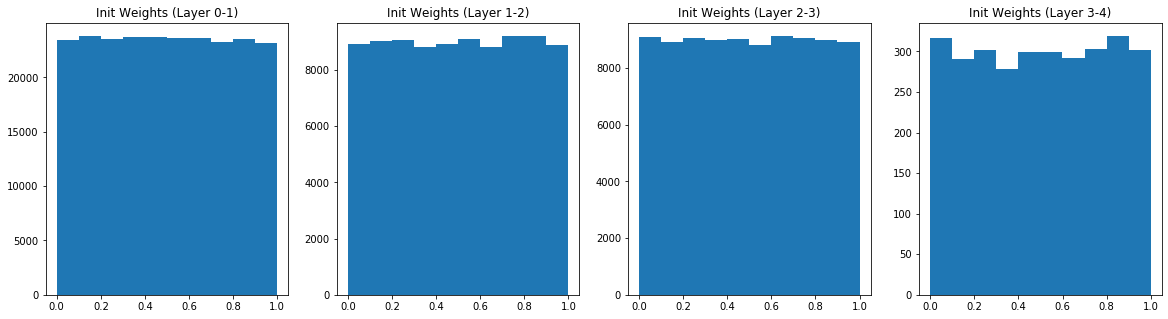

Using cuda


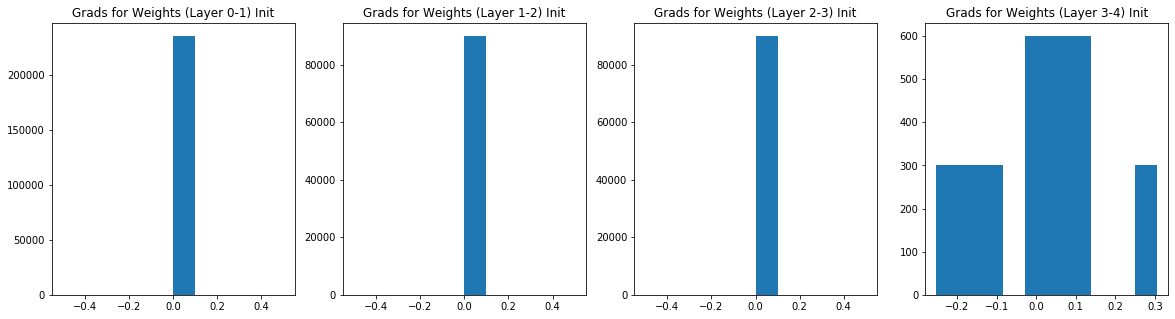

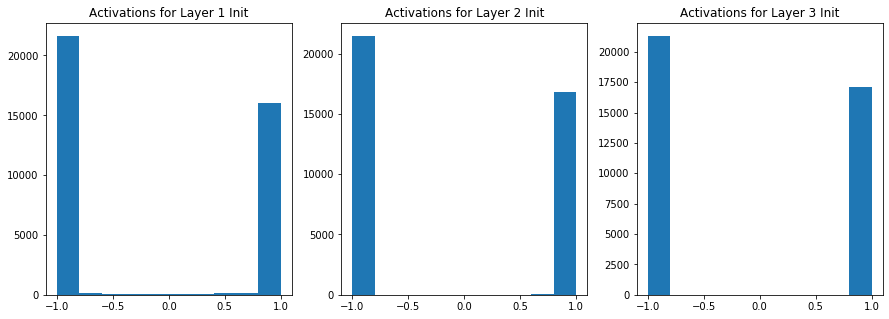

Epoch 0, Train acc: 16.07%, Test acc: 16.87%


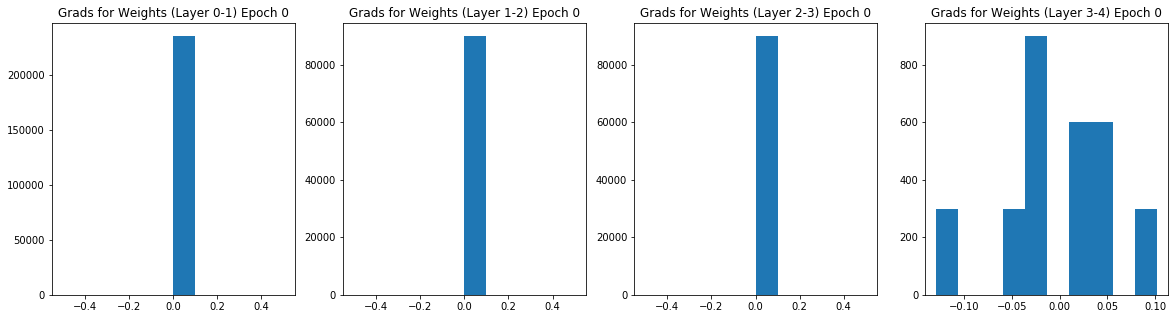

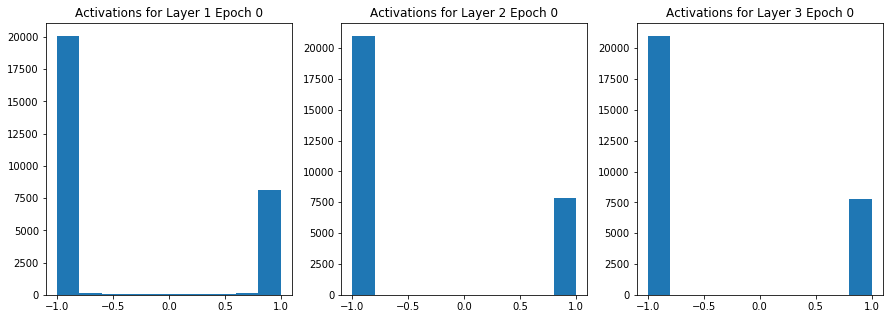

In [ ]:
# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='uniform'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=2, print_every=2, debug=True)

Observation: Still a lot of zeros in the activation

In [ ]:
# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='xavier'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=10, print_every=2, debug=False)

Using cuda
Epoch 0, Train acc: 90.55%, Test acc: 94.71%
Epoch 2, Train acc: 97.30%, Test acc: 96.86%
Epoch 4, Train acc: 98.74%, Test acc: 97.22%
Epoch 6, Train acc: 99.47%, Test acc: 97.36%
Epoch 8, Train acc: 99.83%, Test acc: 97.56%


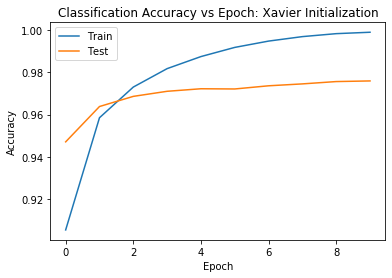

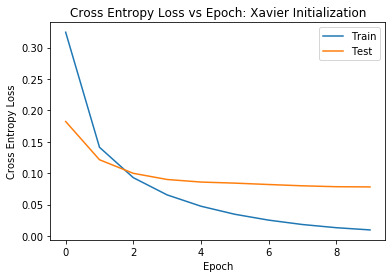

In [ ]:
caption="Xavier Initialization"
plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption)

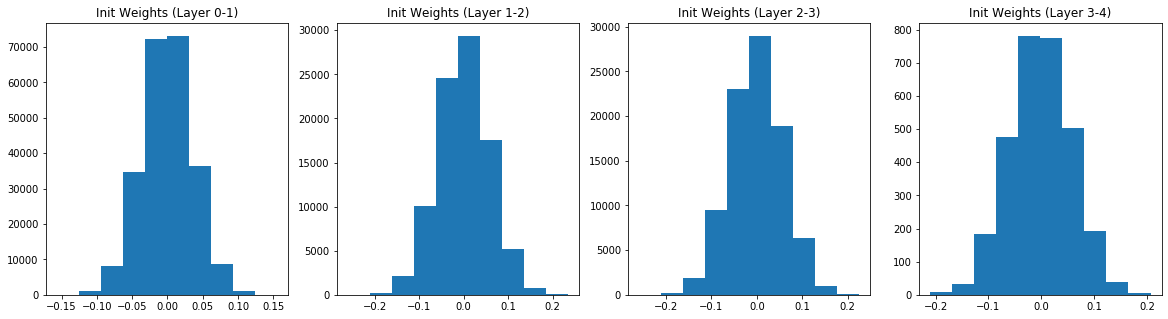

Using cuda


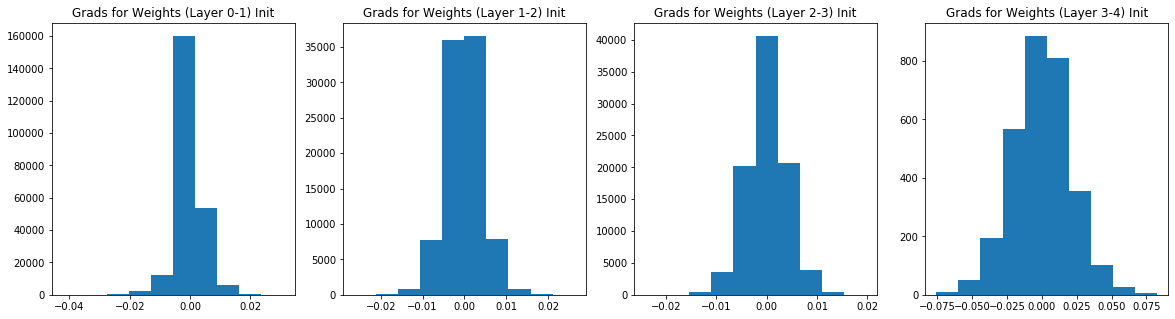

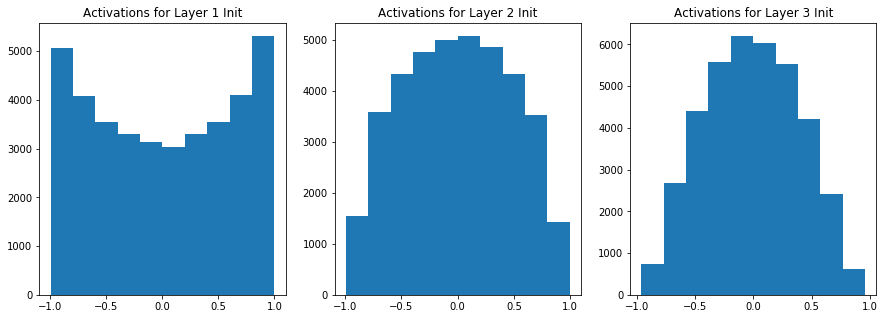

Epoch 0, Train acc: 90.27%, Test acc: 94.74%


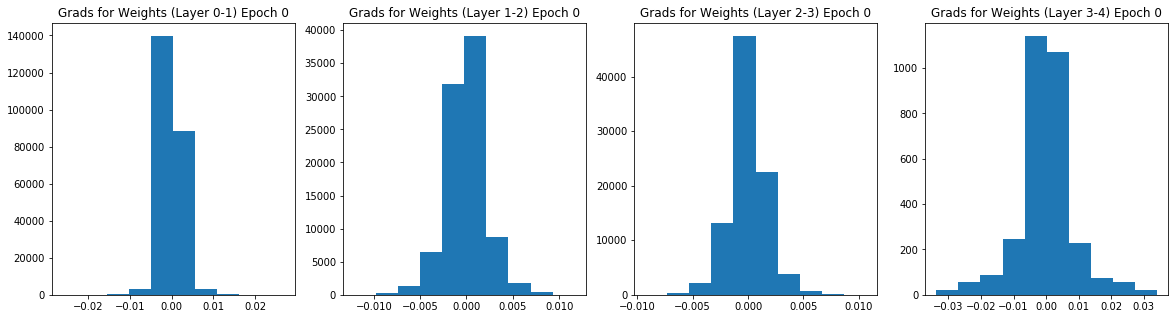

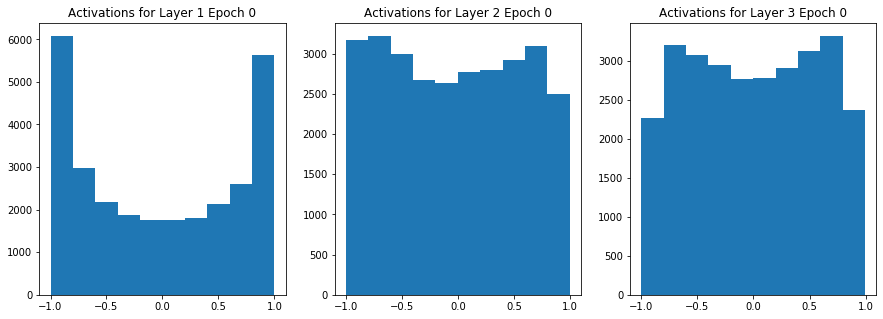

In [ ]:
# Try with debug on for a few epoch

# Instantiate a neural net model
activation_func = torch.tanh
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='xavier'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=2, print_every=2, debug=True)

Compare to network trained with ReLU and with He Initialization

In [ ]:
# Instantiate a neural net model
activation_func = torch.relu
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='he'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=10, print_every=2, debug=False)

Using cuda
Epoch 0, Train acc: 91.36%, Test acc: 94.62%
Epoch 2, Train acc: 98.15%, Test acc: 96.97%
Epoch 4, Train acc: 99.23%, Test acc: 97.50%
Epoch 6, Train acc: 99.73%, Test acc: 97.61%
Epoch 8, Train acc: 99.92%, Test acc: 97.77%


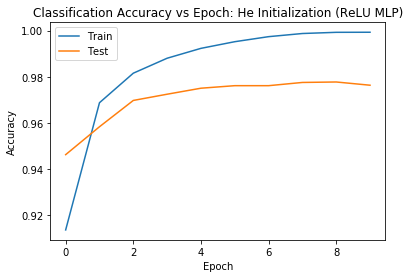

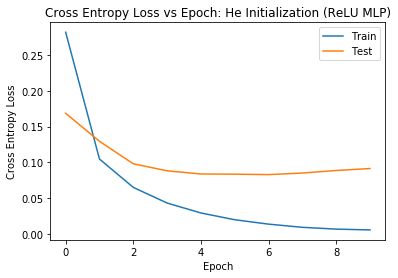

In [ ]:
caption="He Initialization (ReLU MLP)"
plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption)

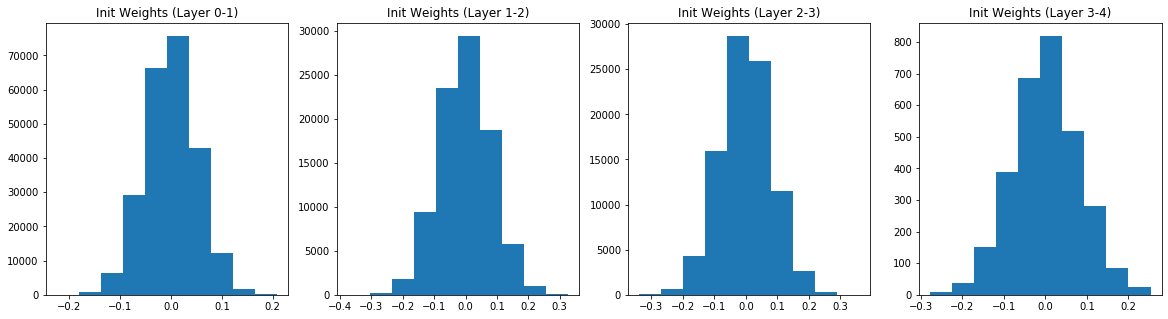

Using cuda


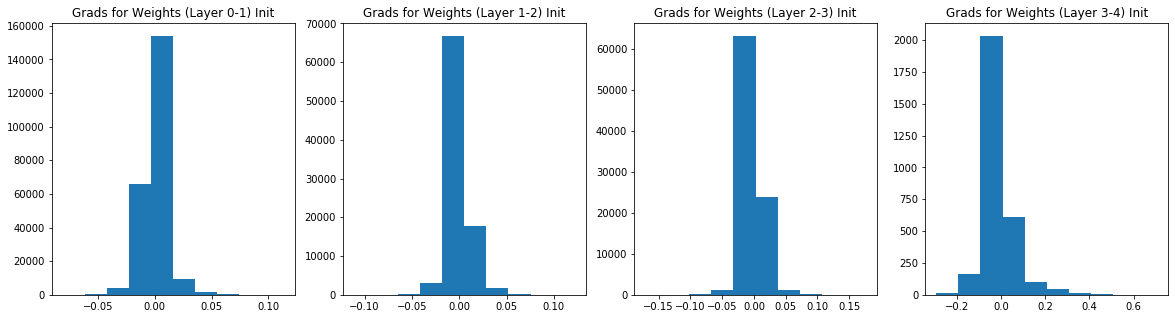

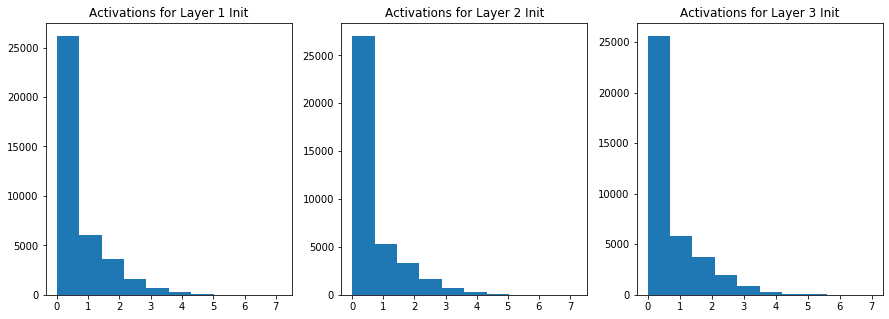

Epoch 0, Train acc: 91.39%, Test acc: 94.88%


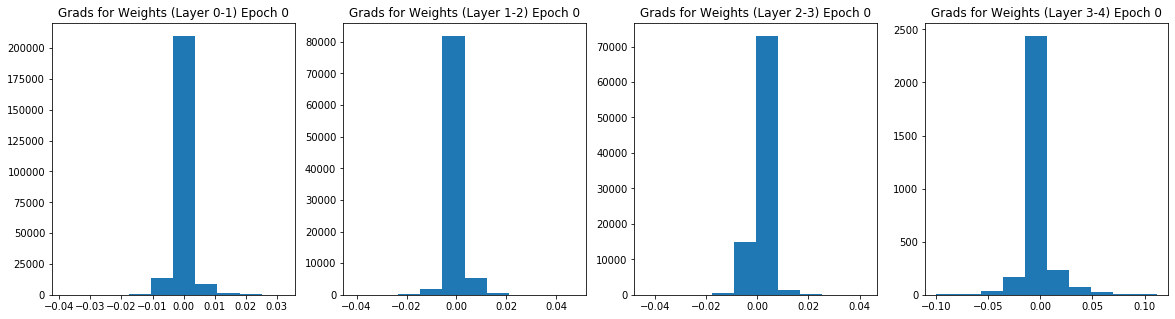

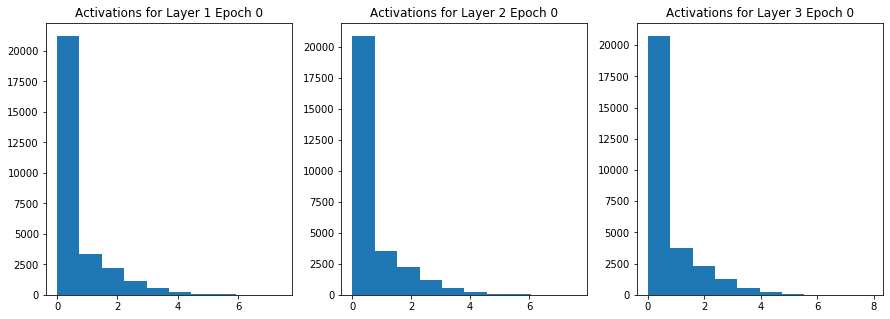

In [ ]:
# Try with debug on for a few epoch

# Instantiate a neural net model
activation_func = torch.relu
model = MLP(activation_func=activation_func)

# Apply initialization
initialization='he'
model = apply_initialization(model, initialization)

# Define optimizer: Choose SGD for now
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Run the training loop 
train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=2, print_every=2, debug=True)

## 2. Optimization

### (Informal) definition

**Optimization**: Minimize (or maximize) some quantity.

Applications:
* Engineering: Minimize fuel consumption of an automobile
* Economics: Maximize returns on an investment
* Supply Chain Logistics: Minimize time taken to fulfill an order
* Life: Maximize happiness


### Formal definition 
* **Goal**: Find $\theta^* = \arg \min_{\theta} f(\theta)$
* **Optimization variable**: $\theta \in \mathbb{R}^n$
* **Objective function**: $f : \mathbb{R}^n \rightarrow \mathbb{R}$
* Note: Maximizing $f$ is equivalent to minimizing $-f$

### Optimization for Machine Learning

* Given a training set: $\{(x_1, y_1),...,(x_n, y_n)\}$
* Prediction function: $h(x; \theta)$
* Define a loss function: $\mathcal{L}(h(x; \theta), y)$
* Find the parameters: $\theta = (\theta_1, ..., \theta_k)$ which minimizes the **empirical risk** $R(\theta)$:
$$\min_\theta R(\theta) = \min_\theta \frac{1}{n} \sum_i^{n} \mathcal{L}(h(x_i;\theta), y_i)$$
* The optimum satisfies:
  - $\nabla R(\theta^*) = 0$
  where $\nabla R(\theta) = \big( \frac{\partial R}{\partial \theta_1}, \frac{\partial R}{\partial \theta_2}, ..., \frac{\partial R}{\partial \theta_k}\big)$
* Sometimes the equation has closed-form solution (e.g. linear regression)

### Gradient Descent Algorithms
We want to minimize the objective function:
$$R(\theta) = \frac{1}{n} \sum_i^{n} f_i (\theta) = \frac{1}{n} \sum_i^{n} \mathcal{L}(h(x_i;\theta), y_i)$$

### **Batch** gradient descent algorithm
* Initialize the parameters randomly
* For each iteration, do until convergence:
$$ \theta^{(k+1)} = \theta^{(k)} - \eta \nabla R(\theta^{(k)}) $$

Note: $\eta \in \mathbb{R}^+$ is the learning rate (a small step)

Geometric interpretation:
* Gradient is perpendicular to the tangent of the level set curve
* Given the current point, negative gradient direction decreases the function fastest

Alterative interpretation
* Minimizing the first-order taylor approx of $f$ keep the new point close to the current point
$$f(x^t) + \nabla f(x^t)^\intercal (x - x^t) + \frac{1}{2\eta} ||x - x^t||_2 ^2$$

<!-- HC TODO: Insert learning rate diagram-->

Convergence criteria
* Change in objective function is close to zero
* Gradient norm is close to zero
* Validation error starts to increase (early-stopping)

### **Stochastic** Gradient Descent Algorithm
* Initialize the parameters randomly
* For each iteration, do until convergence:
  - Randomly select a training sample $i$ (or a small subset of the training samples)
  - Conduct gradient descent:
    $$ \theta^{(k+1)} = \theta^{(k)} - \eta \nabla f_i(\theta^{(k)}) $$

**Intuition**: A noisy approximation of the gradient of the whole dataset

**Pro**: each update requires a small amount of training data, good for training algorithms for a large-scale dataset

**Tips**:
* Subsample *without* replacement so that you visit each point on each pass through the dataset ("epoch")
* Divide the log-likelihood estimate by the size of mini-batches, making learning rate invariant to the mini-batch size.


In [ ]:
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Gradient Descent with Momentum
* Initialize the parameters randomly
* For each iteration, do until convergence:
  - Update the momentum
  $$\delta^{(k+1)} = - \eta \nabla R(\theta^{(k)}) + \alpha \delta^{(k)}$$
  - Conduct gradient descent:
    $$ \theta^{(k+1)} = \theta^{(k)} + \delta^{(k+1)} $$

**Pro**: "accelerate" learning by accumulating some "velocity/momentum" using the past gradients


In [ ]:
# Set momentum parameter (alpha above)sgdm_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


### Nesterov Accelerated Gradient
* Initialize the parameters randomly
* For each iteration, do until convergence:
  - Update the momentum
  $$\delta^{(k+1)} = - \eta \nabla R(\theta^{(k)} + \alpha \delta^{(k)}) + \alpha \delta^{(k)} $$
  - Conduct gradient descent:
    $$ \theta^{(k+1)} = \theta^{(k)} + \delta^{(k+1)} $$

**Intuition**: Look into the future to see how much momentum is required.
* First make a big jump in the direction of the previous accumulated gradient
* Then measure the gradient where you end up and make a correction 

<!-- HC TODO: Add diagram for nesterov -->

In [ ]:
# Set momentum parameter (alpha above)
nesterov_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

### Learning Rate Schedulers: Adagrad
* Initialize the parameters randomly
* For each iteration, do until convergence:
  - Conduct gradient descent for the i-th parameter
  $$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta}{\sqrt{G^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$
  $$ G^{(k,i)} = G^{(k-1,i)} + (\nabla R(\theta^{(k,i)}))^2 $$

**Intuition**: It increases the learning rate for more sparse features and decreases the learning rate for less sparse ones, according to the history of the gradient

In [ ]:
adagrad_optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

### Learning Rate Schedulers: RMSprop/Adadelta
* Initialize the parameters randomly. $\gamma$ is usually set to 0.9
* For each iteration, do until convergence:
  - Conduct gradient descent for the i-th parameter
  $$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta}{\sqrt{G^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$
  $$ G^{(k,i)} = \gamma G^{(k-1,i)} + (1-\gamma)(\nabla R(\theta^{(k,i)}))^2 $$

**Intuition**: Unlike Adagrad, the denominator places a significant weight on the most recent gradient. This also helps avoid decreasing learning rate too much.

In [ ]:
# alpha is the gamma parameter above
rmsprop_optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

### Learning Rate Schedulers: Adam
* Initialize the parameters randomly.
* For each iteration, do until convergence:
  - Conduct gradient descent for the i-th parameter
  $$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta \cdot \hat{m}^{(k,i)}}{\sqrt{\hat{G}^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$
  $$ G^{(k,i)} = \gamma G^{(k-1,i)} + (1-\gamma)(\nabla R(\theta^{(k,i)}))^2 $$
  $$ m^{(k,i)} = \alpha m^{(k-1,i)} + (1-\alpha)\nabla R(\theta^{(k,i)}) $$
  - $\hat{m}^{(k,i)}, \hat{G}^{(k,i)}$ are bias corrected forms of ${m}^{(k,i)}, {G}^{(k,i)}$, respectively

**Note**: Adam is co-authored by Professor Jimmy Ba!


In [ ]:
# betas correspond to alpha and gamma above
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

### Summary: Optimizer algorithms

Method  | Equations
---|---
Gradient Descent (GD) | $$\theta^{(k+1)} = \theta^{(k)} - \eta \nabla f_i(\theta^{(k)}) $$|
GD with Momentum | $\delta^{(k+1)} = - \eta \nabla R(\theta^{(k)} + \alpha \delta^{(k)}$<br> $\theta^{(k+1)} = \theta^{(k)} + \delta^{(k+1)}$ | 
GD with Nesterov Momentum | $\delta^{(k+1)} = - \eta \nabla R(\theta^{(k)} + \alpha \delta^{(k)}) + \alpha \delta^{(k)} $<br> $\theta^{(k+1)} = \theta^{(k)} + \delta^{(k+1)}$ | 
Adagrad |$$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta}{\sqrt{G^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$ <br> $$ G^{(k,i)} = G^{(k-1,i)} + (\nabla R(\theta^{(k,i)}))^2 $$ |
RMSProp |$$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta}{\sqrt{G^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$ <br> $$ G^{(k,i)} = \gamma G^{(k-1,i)} + (1-\gamma)(\nabla R(\theta^{(k,i)}))^2 $$ |
Adam    |$$ \theta^{(k+1),i} = \theta^{(k,i)} + \frac{\eta \cdot \hat{m}^((k,i)}{\sqrt{\hat{G}^{(k,i)} + \epsilon}} \cdot \nabla R(\theta^{(k,i)}) $$ <br> $$ G^{(k,i)} = \gamma G^{(k-1,i)} + (1-\gamma)(\nabla R(\theta^{(k,i)}))^2 $$ <br> $$ m^{(k,i)} = \alpha m^{(k-1,i)} + (1-\alpha)\nabla R(\theta^{(k,i)}) $$ |


In [ ]:
# Instantiate a neural net model
activation_func = torch.relu
model = MLP(activation_func=activation_func)

# Create optimizers
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
sgdm_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
nesterov_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
rmsprop_optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_list = [sgd_optimizer, sgdm_optimizer, nesterov_optimizer, rmsprop_optimizer, adam_optimizer]

train_accs_list = []
test_accs_list = []
train_losses_list = []
test_losses_list = []

for opt in opt_list:
  initialization='he'
  model = apply_initialization(model, initialization)

  # Define optimizer: Choose SGD for now
  print("Optimizer: {}".format(opt))

  # Run the training loop 
  train_accs, test_accs, train_losses, test_losses = train_model(model, opt, train_dl, test_dl, epochs=10, print_every=2, debug=False)
  train_accs_list.append(train_accs)
  test_accs_list.append(test_accs)
  train_losses_list.append(train_losses)
  test_losses_list.append(test_losses)

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Using cuda
Epoch 0, Train acc: 86.27%, Test acc: 91.80%
Epoch 2, Train acc: 94.77%, Test acc: 94.63%
Epoch 4, Train acc: 96.20%, Test acc: 95.79%
Epoch 6, Train acc: 96.98%, Test acc: 96.33%
Epoch 8, Train acc: 97.52%, Test acc: 96.60%
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Using cuda
Epoch 0, Train acc: 91.40%, Test acc: 95.88%
Epoch 2, Train acc: 98.20%, Test acc: 96.56%
Epoch 4, Train acc: 99.31%, Test acc: 97.08%
Epoch 6, Train acc: 99.83%, Test acc: 97.71%
Epoch 8, Train acc: 99.94%, Test acc: 97.65%
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
Using cuda
Epoch 0, Train acc: 92.28%, Test acc: 95.46%
Epoch 2, Train acc: 98.23%, Test acc: 96.82%
Epoch 4, Train acc: 99.36%, Test acc: 97.14%
Epoch 6, T

Text(0.5, 1.0, 'Cross Entropy Loss vs Epoch: Optimizers')

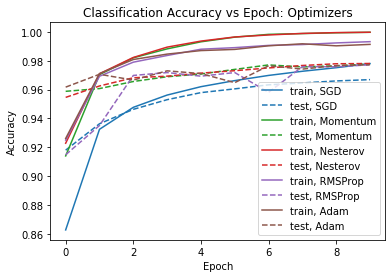

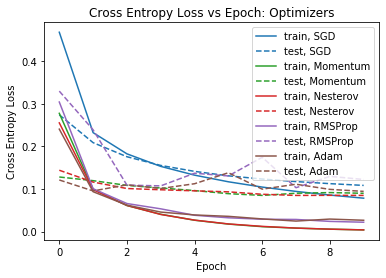

In [ ]:
# Visualize the loss / acc
caption = "Optimizers"
color_list = ['#1f77b4',
              '#2ca02c',
              '#d62728',
              '#9467bd',
              '#8c564b',
              '#7f7f7f',
              '#bcbd22'
            ]
idx = 0
opt_name_list = ["SGD", "Momentum", "Nesterov", "RMSProp", "Adam"]
for (opt_name, train_accs, test_accs) in zip(opt_name_list, train_accs_list, test_accs_list):
  plt.plot(train_accs, label="train, {}".format(opt_name), color=color_list[idx])
  plt.plot(test_accs, label="test, {}".format(opt_name), linestyle="--", color=color_list[idx])
  idx += 1
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Classification Accuracy vs Epoch: {}".format(caption))


# Visualize the loss / acc
plt.figure()
idx = 0
for (opt_name, train_losses, test_losses) in zip(opt_name_list, train_losses_list, test_losses_list): 
  plt.plot(train_losses, label="train, {}".format(opt_name), color=color_list[idx])
  plt.plot(test_losses, label="test, {}".format(opt_name), linestyle="--", color=color_list[idx])
  idx += 1
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

## Learning Rate
<!-- HC TODO: Insert gradient descent diagram-->

A good learning rate should be:
* Should not be too big (objective will blow up)
* Should not be too small (takes longer to convergent)


### Tuning Learning Rate

Grid search
* Optimize your model with a large learning rate (e.g. 0.1) and then progressively reduce this rate, often by an order of magnitude (0.1, 0.01, 0.001,...)
* The idea is to find the highest stable learning rate

Learning rate decay
* Gradually reduce the learning rate after epochs
  - **Step Decay**: reduce by factor every few epochs (e.g. a half every 5 epochs, or by 0.1 every 20 epochs), or when validation error stops improving
  - **Exponential decay**: The learning rate at iteration $t$ is $\eta(t)$, defined with hyperparameters $\eta_0,k$:
    $$\eta(t) = \eta_0 e^{-kt}$$
  - **1/t decay**: Similar hyperparameters but with the following equation:
    $$\eta(t) = \frac{\eta_0}{1 + kt} $$
* Intuition: supervision signal is strong at early stage and you don’t want to change too much after it’s learnt well



Random Search
* Argued by Bergstra and Bengio in [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), "Randomly chosen trials are more efficient for hyper parameter optimization than trials on a grid"

<!-- HC TODO: Insert random search vs grid search diagram -->



#### Experiment with different base learning rate

In [ ]:
# Instantiate a neural net model
activation_func = torch.relu
model = MLP(activation_func=activation_func)

# Apply initialization
lr_list = [0.1, 0.01, 0.001]
train_accs_list = []
test_accs_list = []
train_losses_list = []
test_losses_list = []

for lr in lr_list:
  initialization='he'
  model = apply_initialization(model, initialization)

  # Define optimizer: Choose SGD for now
  print("Learning rate: {}".format(lr))
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  # Run the training loop 
  train_accs, test_accs, train_losses, test_losses = train_model(model, optimizer, train_dl, test_dl, epochs=10, print_every=2, debug=False)
  train_accs_list.append(train_accs)
  test_accs_list.append(test_accs)
  train_losses_list.append(train_losses)
  test_losses_list.append(test_losses)

Learning rate: 0.1
Using cuda
Epoch 0, Train acc: 91.47%, Test acc: 93.80%
Epoch 2, Train acc: 97.25%, Test acc: 96.65%
Epoch 4, Train acc: 98.30%, Test acc: 97.42%
Epoch 6, Train acc: 98.74%, Test acc: 96.98%
Epoch 8, Train acc: 98.71%, Test acc: 97.00%
Learning rate: 0.01
Using cuda
Epoch 0, Train acc: 91.54%, Test acc: 95.34%
Epoch 2, Train acc: 98.14%, Test acc: 96.84%
Epoch 4, Train acc: 99.29%, Test acc: 97.54%
Epoch 6, Train acc: 99.78%, Test acc: 97.88%
Epoch 8, Train acc: 99.94%, Test acc: 97.90%
Learning rate: 0.001
Using cuda
Epoch 0, Train acc: 84.32%, Test acc: 92.21%
Epoch 2, Train acc: 94.48%, Test acc: 94.77%
Epoch 4, Train acc: 96.06%, Test acc: 95.87%
Epoch 6, Train acc: 96.91%, Test acc: 96.30%
Epoch 8, Train acc: 97.49%, Test acc: 96.66%


Text(0.5, 1.0, 'Cross Entropy Loss vs Epoch: Learning Rates')

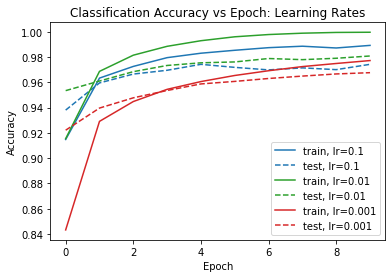

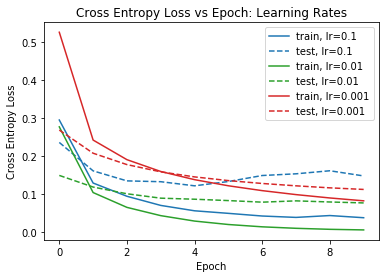

In [ ]:
# Visualize the loss / acc
caption = "Learning Rates"
color_list = ['#1f77b4',
              '#2ca02c',
              '#d62728',
              '#9467bd',
              '#8c564b'
            ]
idx = 0
for (lr, train_accs, test_accs) in zip(lr_list, train_accs_list, test_accs_list):
  plt.plot(train_accs, label="train, lr={}".format(lr), color=color_list[idx])
  plt.plot(test_accs, label="test, lr={}".format(lr), linestyle="--", color=color_list[idx])
  idx += 1
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Classification Accuracy vs Epoch: {}".format(caption))


# Visualize the loss / acc
plt.figure()
idx = 0
for (lr, train_losses, test_losses) in zip(lr_list, train_losses_list, test_losses_list): 
  plt.plot(train_losses, label="train, lr={}".format(lr), color=color_list[idx])
  plt.plot(test_losses, label="test, lr={}".format(lr), linestyle="--", color=color_list[idx])
  idx += 1
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

Learning rate of 0.01 is the best among [0.1, 0.01, 0.001]

#### Experiment with different learning rate decay

In [ ]:
# TODO: Show different learning rate decay 